# Social Media Sentiment Analysis Pipeline

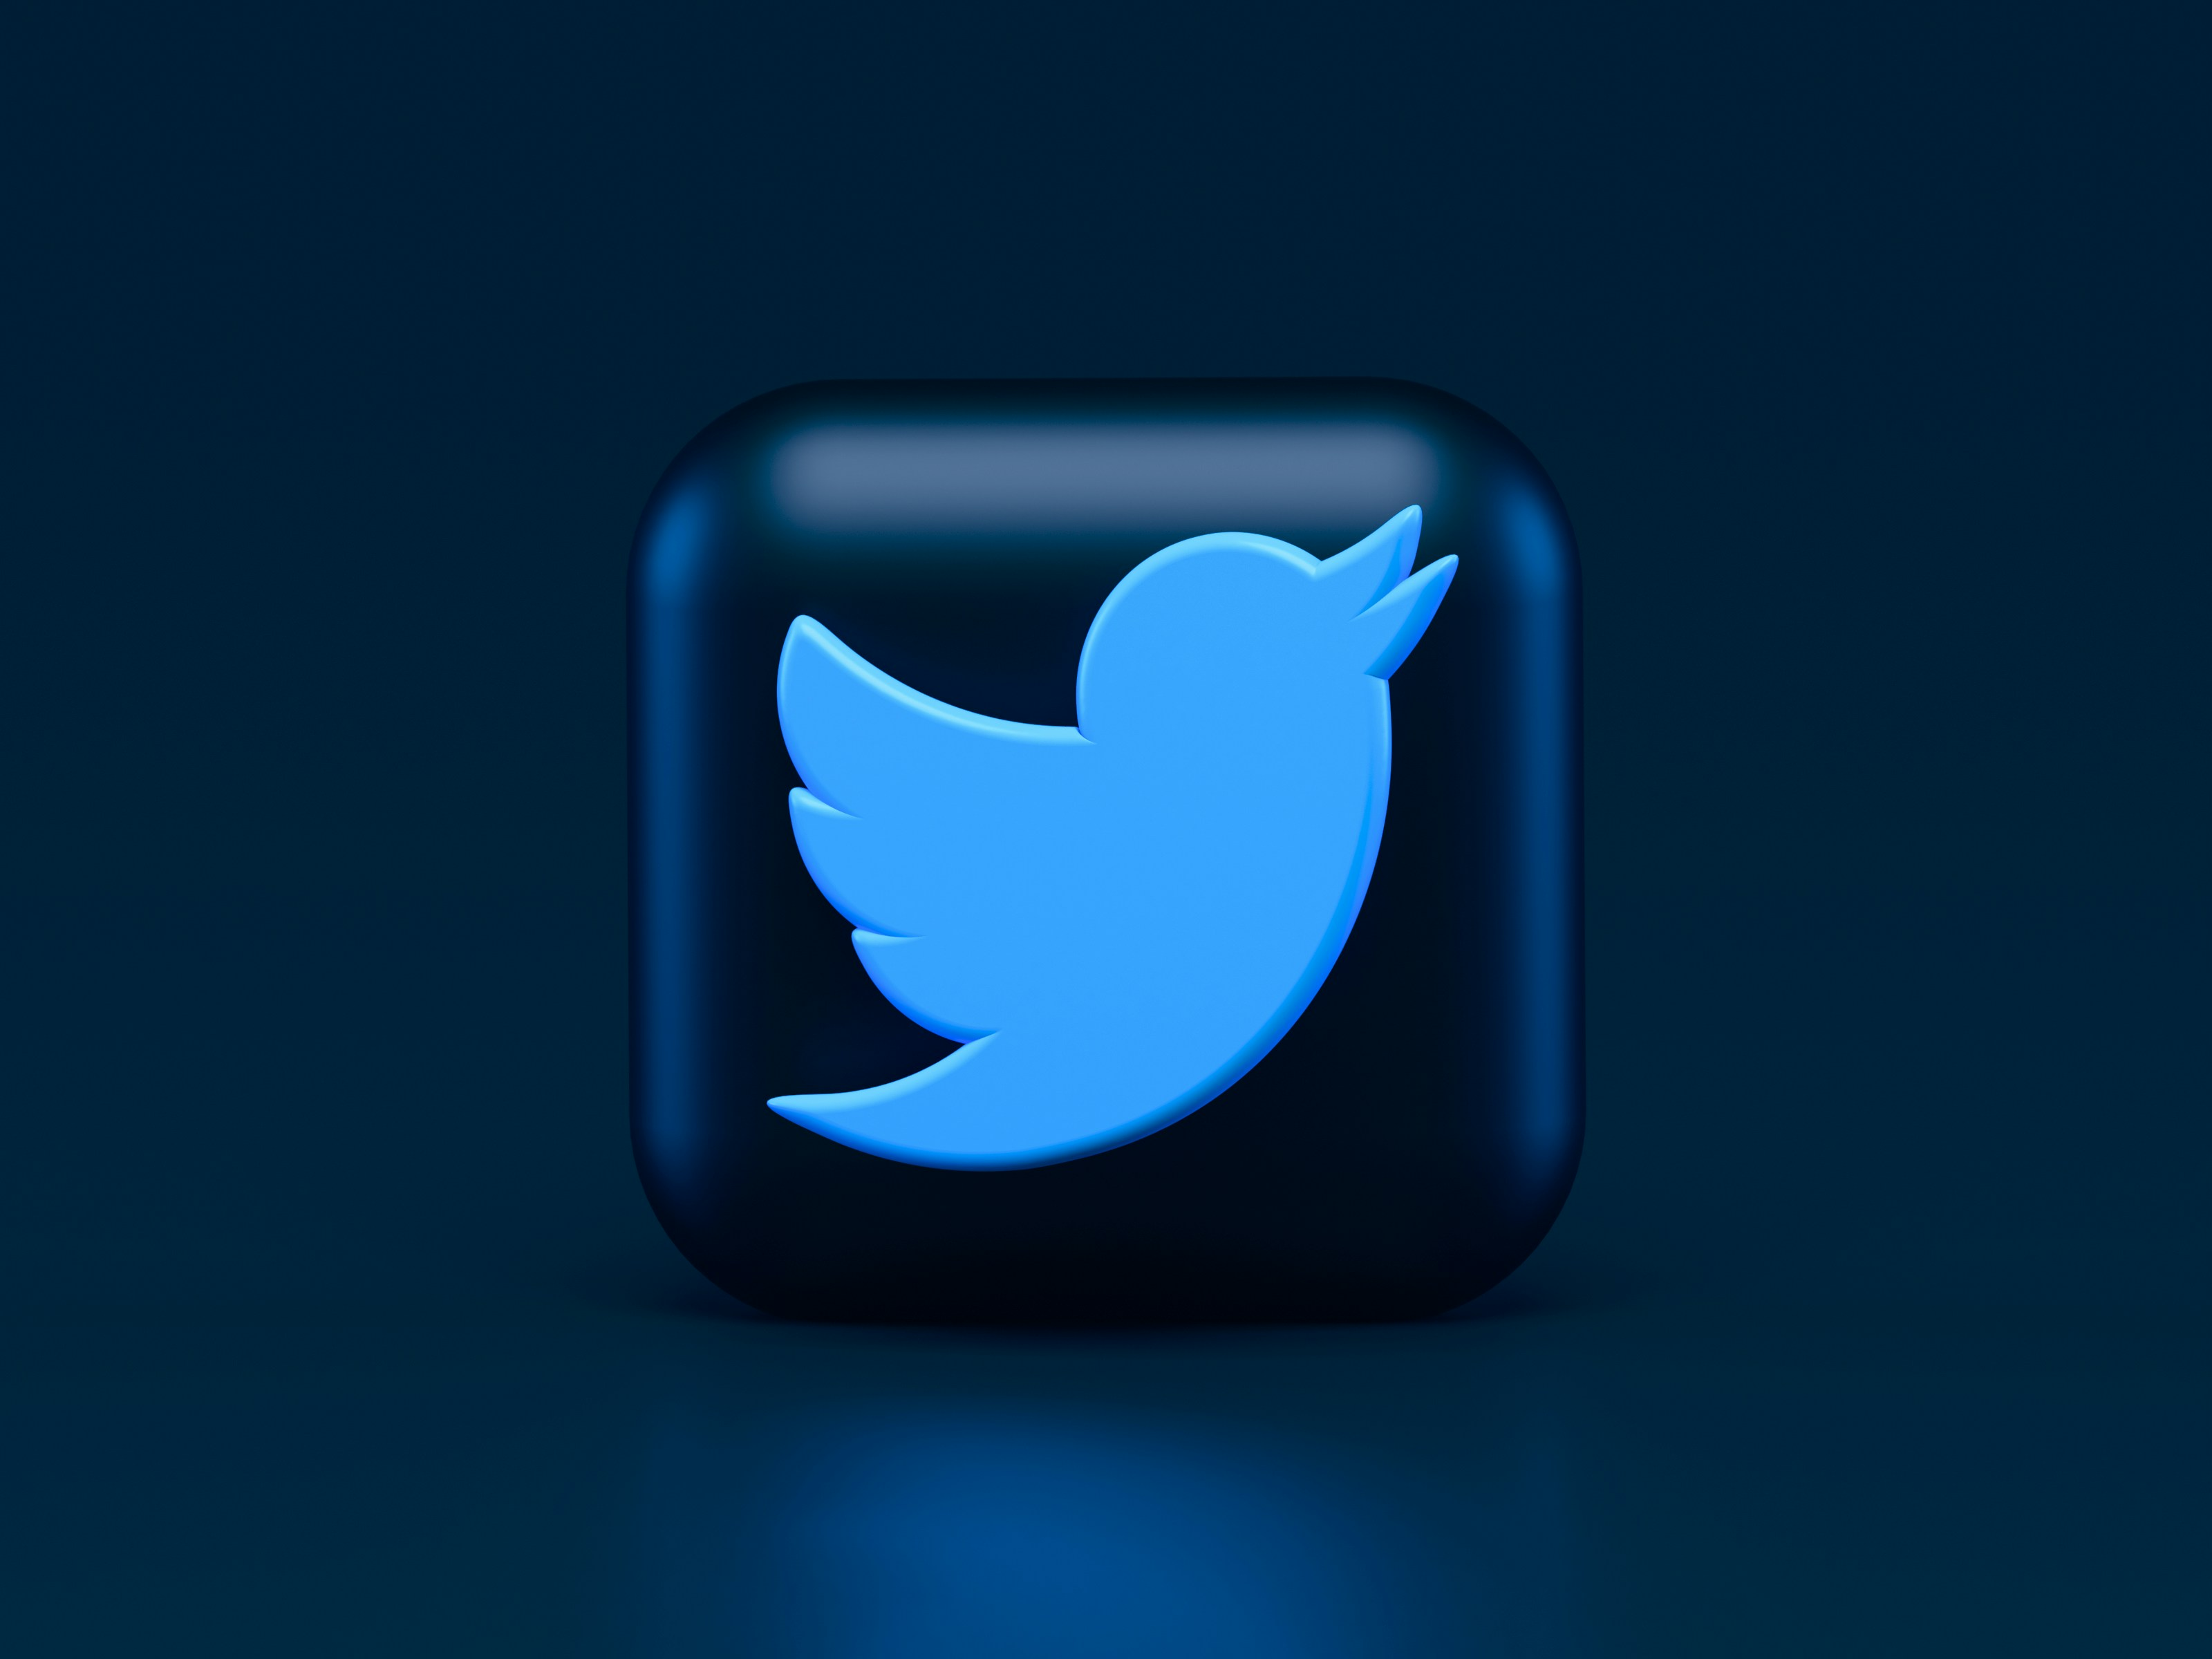

In this project, we leverage the power of big data processing with Apache Spark to perform ETL (Extract, Transform, Load) operations on a dataset of 1.6 million tweets. First, Spark is used to load the dataset and perform any necessary transformations, including data cleaning, filtering, and pre-processing of text for sentiment analysis. After the transformations, the processed data is saved into a CSV file, making it ready for analysis in a more lightweight environment.

Using Pandas, we load the CSV into a DataFrame and further explore the dataset, preparing it for sentiment classification. For the machine learning component, we build and train a sentiment analysis model using TensorFlow, designed to classify tweets into positive or negative sentiments. To enhance our understanding of the data and model performance, we also create visualizations with Matplotlib, which help to interpret trends in sentiment distribution, model accuracy, and other key metrics.

By combining Spark’s scalable ETL capabilities with the versatility of TensorFlow and the analytical power of Pandas, this notebook demonstrates an end-to-end workflow for large-scale sentiment analysis in social media data.

I'll begin by installing and importing necessary libraries:

In [1]:
!pip install -q pyspark==3.1.2

In [2]:
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col, sum, when, lower, udf, regexp_replace, split
from pyspark.sql.types import StringType, ArrayType
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
import kagglehub
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from google.colab import drive
import glob
%matplotlib inline

## Extract Data

Next we can use spark to extract the dataset from the CSV. We will be using the kaggle [Sentiment Analysis dataset by kazanova.](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [3]:
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()


path = kagglehub.dataset_download("kazanova/sentiment140")

data = spark.read.csv(path,
                      header=False,
                      encoding="ISO-8859-1",
                      inferSchema=True)

data.show(5)


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



## Transform Data

Now it's time to begin cleaning and transforming the data for later use. This step is the longest and requires some exploratory analysis. We'll begin by changing the column names to something more relevant based off of the key for the dataset:

In [4]:
data = data.toDF("label", "id", "date", "flag", "user", "text")

data.show(5)

+-----+----------+--------------------+--------+---------------+--------------------+
|label|        id|                date|    flag|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+-----+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [5]:
data.orderBy("label", ascending=False).show(5)

+-----+----------+--------------------+--------+--------------+--------------------+
|label|        id|                date|    flag|          user|                text|
+-----+----------+--------------------+--------+--------------+--------------------+
|    4|1548615857|Fri Apr 17 21:27:...|NO_QUERY|   Kalediscope|@tiffmcmillan yea...|
|    4|1548615927|Fri Apr 17 21:27:...|NO_QUERY|      Juliaa19|@chelseacw basica...|
|    4|1548615967|Fri Apr 17 21:27:...|NO_QUERY|   natsattacks|aw yay :] good is...|
|    4|1548615993|Fri Apr 17 21:27:...|NO_QUERY|ReggaeGirl_Yve|@danecook ..watch...|
|    4|1548616025|Fri Apr 17 21:27:...|NO_QUERY|  tiffanyroolz|Oprah and ashton ...|
+-----+----------+--------------------+--------+--------------+--------------------+
only showing top 5 rows



Now we can begin to look at the data more deeply. Let's get an idea of the size and content of our dataset:

In [6]:
# Number of rows
num_rows = data.count()

# Number of columns
num_columns = len(data.columns)

print(f"Shape: ({num_rows}, {num_columns})")

Shape: (1600000, 6)


In [7]:
data.describe().show()

+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|             label|                  id|                date|    flag|                user|                text|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|               2.0|1.9988175522956276E9|                null|    null| 4.325887521835714E9|                null|
| stddev|2.0000006250002933|1.9357607362269536E8|                null|    null|5.162733218454890...|                null|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|                 4|          2329205794|Wed May 27 07:27:...|NO_QUERY|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+---------------

In [8]:
data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [9]:
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
print("Num of Null Values:")
null_counts.show()

Num of Null Values:
+-----+---+----+----+----+----+
|label| id|date|flag|user|text|
+-----+---+----+----+----+----+
|    0|  0|   0|   0|   0|   0|
+-----+---+----+----+----+----+



Now some changes that will help when it comes time to training our model. First we keep the most important columns for our model: label and text. Next, the key states that data has a label of 4 if it is considered positive and 0 if it is negative. We shall change the label of 4 to 1 for simplicity and to keep our data labels binary:

In [10]:
data = data.select("text", "label")
data = data.withColumn("label", when(data["label"] == 4, 1).otherwise(data["label"]))


Next we limit the data to 20,000 rows for both positive and negative sentiment texts. This is to make it simpler to run our model when it comes time to train.

In [11]:
# Filter for positive labels (label == 1)
data_pos = data.filter(data["label"] == 1)

# Filter for negative labels (label == 0)
data_neg = data.filter(data["label"] == 0)

In [12]:
# Limit to 20,000 rows for each subset
data_pos = data_pos.limit(20000)
data_neg = data_neg.limit(20000)

In [13]:
data = data_pos.union(data_neg)

Putting all text into lowercase for uniformity:

In [14]:
data = data.withColumn("text", lower(data["text"]))

In [15]:
data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|i love @health4ua...|
|im meeting up wit...|
|@darealsunisakim ...|
|being sick can be...|
|@lovesbrooklyn2 h...|
+--------------------+
only showing top 5 rows



In [16]:
data.orderBy("text", ascending=False).select("text").show(5)

+--------------------+
|                text|
+--------------------+
|ï¿½we make a livi...|
|ï¿½nce terminator...|
|ï¿½ber sick  tryi...|
|ï¿½356 to make my...|
|ï¿½ i am loving c...|
+--------------------+
only showing top 5 rows



Next begins the cleaning. We will start by removing the stopwords from our text, as they are often inefficient when it comes to communicating important information in text:

In [17]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [18]:
STOPWORDS = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])

cleaning_stopwords_udf = udf(cleaning_stopwords, StringType())

data = data.withColumn("text", cleaning_stopwords_udf("text"))


data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love @health4uand...|
|im meeting one be...|
|@darealsunisakim ...|
|sick really cheap...|
|@lovesbrooklyn2 e...|
+--------------------+
only showing top 5 rows



Next to clean the punctuation in our text as well:

In [19]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

cleaning_punctuations_udf = udf(cleaning_punctuations, StringType())


data = data.withColumn("text", cleaning_punctuations_udf("text"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love health4uandp...|
|im meeting one be...|
|darealsunisakim t...|
|sick really cheap...|
|lovesbrooklyn2 ef...|
+--------------------+
only showing top 5 rows



And also any repeating characters we may have:

In [20]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

cleaning_repeating_char_udf = udf(cleaning_repeating_char, StringType())

data = data.withColumn("text", cleaning_repeating_char_udf("text"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love health4uandp...|
|im meting one bes...|
|darealsunisakim t...|
|sick realy cheap ...|
|lovesbroklyn2 efe...|
+--------------------+
only showing top 5 rows



In [21]:
data.orderBy("text", ascending=False).select("text").show(5)

+--------------------+
|                text|
+--------------------+
|ï¿½we make living...|
|ï¿½nce terminator...|
|ï¿½ber sick tryin...|
|ï¿½356 make porly...|
|ï¿½18 thats bril ...|
+--------------------+
only showing top 5 rows



Now to clean any extra email data, url data, or numbers from our text:

In [22]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

cleaning_email_udf = udf(cleaning_email, StringType())

data = data.withColumn("text", cleaning_email_udf("text"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love health4uandp...|
|im meting one bes...|
|darealsunisakim t...|
|sick realy cheap ...|
|lovesbroklyn2 efe...|
+--------------------+
only showing top 5 rows



In [23]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

cleaning_URLs_udf = udf(cleaning_URLs, StringType())

data = data.withColumn("text", cleaning_URLs_udf("text"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love health4uandp...|
|im meting one bes...|
|darealsunisakim t...|
|sick realy cheap ...|
|lovesbroklyn2 efe...|
+--------------------+
only showing top 5 rows



In [24]:
data.orderBy("text", ascending=False).select("text").show(5)

+--------------------+
|                text|
+--------------------+
|ï¿½we make living...|
|ï¿½nce terminator...|
|ï¿½ber sick tryin...|
|ï¿½356 make porly...|
|ï¿½18 thats bril ...|
+--------------------+
only showing top 5 rows



In [25]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

cleaning_numbers_udf = udf(cleaning_numbers, StringType())

data = data.withColumn("text", cleaning_numbers_udf("text"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|love healthuandpe...|
|im meting one bes...|
|darealsunisakim t...|
|sick realy cheap ...|
|lovesbroklyn efec...|
+--------------------+
only showing top 5 rows



Now to "tokenize" the text, or seperate it into individual words:

In [26]:
data = data.withColumn("text", regexp_replace("text", r"[^a-zA-Z0-9\s]", ""))  # Remove special characters
data = data.withColumn("text", split("text", "\s+"))

data.select("text").show(5)

+--------------------+
|                text|
+--------------------+
|[love, healthuand...|
|[im, meting, one,...|
|[darealsunisakim,...|
|[sick, realy, che...|
|[lovesbroklyn, ef...|
+--------------------+
only showing top 5 rows



And now to lemmatize the text (reduce the words to their base):

In [27]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

lemmatizer_on_text_udf = udf(lemmatizer_on_text, StringType())

data = data.withColumn("text", lemmatizer_on_text_udf("text"))

data.select("text").show(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+--------------------+
|                text|
+--------------------+
|[love, healthuand...|
|[im, meting, one,...|
|[darealsunisakim,...|
|[sick, realy, che...|
|[lovesbroklyn, ef...|
+--------------------+
only showing top 5 rows



## Load Data

Now that the data is cleaned and transformed, we will load our preprocessed data somewhere for later use in our model. In this instance, it will be loaded into google drive.

In [28]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data.write.csv("/content/drive/MyDrive/processed_sentiment_data.csv", header=True)

## Sentiment Analysis

In this section, we dive into the sentiment analysis portion of the project, where we classify tweets into positive and negative sentiments. We will load in our preprocessed data from above, and build a TensorFlow model to capture sentiment patterns in tweet text, ultimately predicting the sentiment for each tweet.

In [30]:

all_files = glob.glob("/content/drive/MyDrive/processed_sentiment_data.csv/part-*.csv")

In [31]:
processed_data = pd.concat((pd.read_csv(f) for f in all_files))
processed_data.head()

,text,label
0,"[love, healthuandpets, u, guys, r, best]",1
1,"[im, meting, one, besties, tonight, cant, wait...",1
2,"[darealsunisakim, thanks, twiter, ad, sunisa, ...",1
3,"[sick, realy, cheap, hurts, much, eat, real, f...",1
4,"[lovesbroklyn, efect, everyone]",1


In [32]:
processed_data.tail()

,text,label
19995,"[much, time, wekend, work, trip, malm, frisat,...",0
19996,"[one, day, holidays]",0
19997,"[feling, right, hate, damn, humprey]",0
19998,"[gezi, hv, read, whole, bok, personality, type...",0
19999,"[threw, sign, donie, bent, get, thinge, made, ...",0


In [33]:
X = processed_data['text']
y = processed_data['label']

Now we will use the Tokenizer, which converts the text into a sequence of characters. We will only use the 2,000 most frequent words from our dataset to focus on only the most important words. We are also limiting the length of our sequences to 500 words.

In [35]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [36]:
sequences_matrix.shape

(40000, 500)

Now we split the data into training and testing splits. We split it so that 70% of the data is used for training and the other 30% for testing:

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

Next we build a binary classification model in TensorFlow. Our model will include a LSTM layer for handling the sequential text data:

In [38]:
def tf_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

With this being a binary classification model, we will use binary cross entropy as our loss function. This is what we will be minimizing during training. In order to optimize this we will be using the Root Mean Square Propagation. We will use accuracy as our target metric:

In [40]:
model = tf_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [42]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=8, validation_split=0.1)
print('Training finished')

Epoch 1/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 152s 482ms/step - accuracy: 0.7501 - loss: 0.5151 - val_accuracy: 0.7336 - val_loss: 0.5241
Epoch 2/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 153s 485ms/step - accuracy: 0.7683 - loss: 0.4891 - val_accuracy: 0.7436 - val_loss: 0.5222
Epoch 3/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 198s 473ms/step - accuracy: 0.7710 - loss: 0.4861 - val_accuracy: 0.7400 - val_loss: 0.5214
Epoch 4/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 148s 470ms/step - accuracy: 0.7746 - loss: 0.4739 - val_accuracy: 0.7425 - val_loss: 0.5263
Epoch 5/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 202s 471ms/step - accuracy: 0.7724 - loss: 0.4774 - val_accuracy: 0.7350 - val_loss: 0.5230
Epoch 6/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 203s 475ms/step - accuracy: 0.7757 - loss: 0.4754 - val_accuracy: 0.7368 - val_loss: 0.5274
Epoch 7/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 149s 475ms/step - accuracy: 0.7848 - loss: 0.4542 - val_accuracy: 0.7361 - val_loss: 0.5489
Epoch 8/8
315/315 ━━━━━━━━━━━━━━━━━━━━ 155s 491ms/step - accuracy: 0.7961 - loss: 0

In [43]:
accr1 = model.evaluate(X_test,Y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.7462 - loss: 0.5231


So our model has an accuracy of ~75%. Now to make some predictions using our newly trained model:

In [44]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step


And we will use a confusion matrix to visualize the predictions. Specifically, we can see the number of false positives and negatives as well as the number of true positives and negatives to get a better idea of the distribution of our predictions:

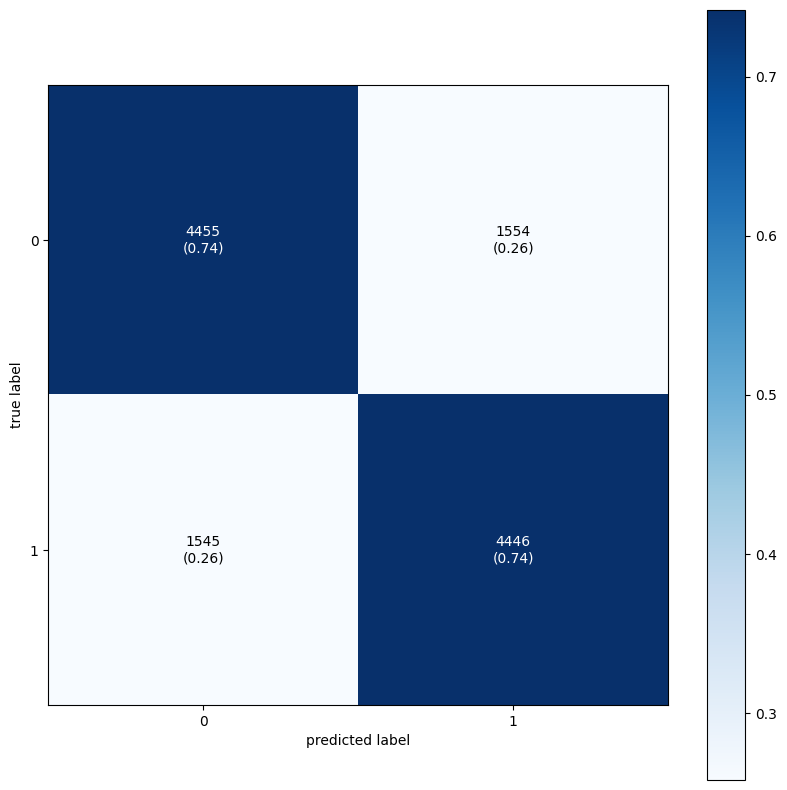

In [45]:
CR=confusion_matrix(Y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Below we also visualize the ROC curve, which shows our model's abilty to discriminate between classes. We also calculate the AUC (area under the curve) which shows the model's overall performance:

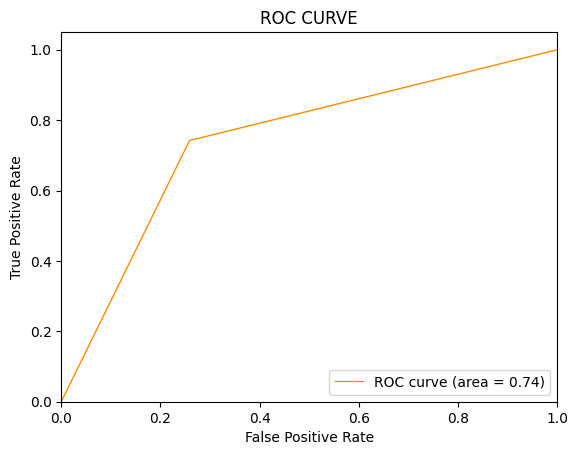

In [46]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()